---
# Anomaly Detection Project Scratchpad
---

## Imports
---

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearn import metrics
import env

import acquire as a

---
## Acquire
---

In [25]:
# lets get the data
df = a.get_log_data()

In [26]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [27]:
df.shape

(900223, 15)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


Initial Observations:
- None of the dates are in datetime format, that needs to be corrected
    - `date`, `time`, `start_date`, `end_date`, `created_at`, `updated_at`
- The date of access needs to become index column, but I need to figure out how to merge the date and time columns info a single datetime index
- The path column needs to be split out into several columns for future use 
    - Use Zach's function to do this and just make necessary changes for this path format
- `user_id` is the unique identifier for each student
- `cohort_id` and `id` should be the same since that is what I joined on and there should be some nulls somewhere since inner and left join produced different results
    - Take a look at this before dropping one of the columns just to see what's going on
    - These columns are currently both floats, so for whichever I decide to keep, I will most likely convert to integer
- `ip` seems to be able to be left as-is
    - Just need to be careful with this potentially sensitive data
- `name` seems to be good as-is
- `slack` not sure if this will be useful
- `start_date` and `end_date` will allow us to determine if people are accessing the curriculum after they finish and what they are accessing
    - If students are accessing curriculum before their start date, this is an issue since they shouldn't have access until they are granted access through github on the first week or so of class
- `created_at` and `updated_at` columns seem to be just when the entry was created for the cohort identification table
    - Probably won't be super useful
    - Can see if any have been updated since dates seem to be mostly the same
- `deleted_at`
    - See if any were deleted
    - If they were, I would wonder why
- `program_id'
    - This could be mapped to name of program
        - Data Science, Web Dev, and then I would need to ask instructors what any other categories might mean
        - 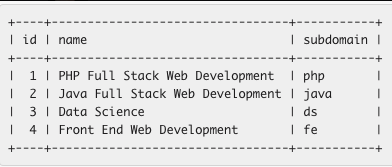

---
## Prepare/Get to know data
---

### `date` and `time`

In [29]:
# add them together as strings
df['date'] = df.date + ' ' + df.time

In [30]:
# and then convert to datetime
df.date = pd.to_datetime(df.date)

In [44]:
# then covert this into index
df = df.set_index(df.date)

In [47]:
# drop columns that have been converted to index
df = df.drop(columns=['date', 'time'])

---
### `path`

In [58]:
df.tail(50)

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2021-04-21 16:10:52,html-css/css-ii/bootstrap-grid-system,925,138.0,70.121.221.55,138.0,Neptune,#neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,NaN,2.0
2021-04-21 16:12:05,jquery,869,135.0,136.50.98.51,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0
2021-04-21 16:12:08,java-i/introduction-to-java,866,135.0,99.65.201.242,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0
2021-04-21 16:12:10,jquery/selectors,869,135.0,136.50.98.51,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0
2021-04-21 16:12:45,jquery/events,869,135.0,136.50.98.51,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0
2021-04-21 16:12:46,java-iii,825,134.0,193.56.117.60,134.0,Luna,#luna,2020-12-07,2021-06-08,2020-12-07 16:58:43,2020-12-07 16:58:43,NaN,2.0
2021-04-21 16:12:47,java-iii/user-input,825,134.0,193.56.117.60,134.0,Luna,#luna,2020-12-07,2021-06-08,2020-12-07 16:58:43,2020-12-07 16:58:43,NaN,2.0
2021-04-21 16:12:48,jquery/events/mouse-events,869,135.0,136.50.98.51,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0
2021-04-21 16:12:55,jquery/events/keyboard-events,869,135.0,136.50.98.51,135.0,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,NaN,2.0


- Looks like most paths only have 2 parts, the section and the specific page
- I do see some with 3 though
- Is it even necessary to split up the path?
- Each current path points to a lesson, so it should be fine as-is
- If I wanted to look at modules instead of lessons, I might need to split it out
    - I will tackle that if I have enough time at the end

In [62]:
# split the path up into sections using the split string method and the "/" as the delimiter
df.path[2].split('/') 

['java-ii', 'object-oriented-programming']

In [ ]:
str.split('/')

In [65]:
entry = df.path[2]
entry

'java-ii/object-oriented-programming'

In [66]:
parts = entry.split('/')
parts

['java-ii', 'object-oriented-programming']

In [67]:
output = {}

In [69]:
output['module'] = parts[0]
output

{'module': 'java-ii'}

In [71]:
output['lesson'] = parts[1]
output

{'module': 'java-ii', 'lesson': 'object-oriented-programming'}

In [75]:
# my first draft of a function to parse this thing
def parse_path(entry):
    parts = entry.split('/')
    output = {}
    output['module'] = parts[0]
    output['lesson'] = parts[1]
    if len(parts) > 2:
        output['section'] = parts[1:]
    return pd.Series(output)
# this won't work in it's current state because some entries only have 1 item in the list
# would need to either do some cleaning first or add more if statements

In [76]:
# df = df.path.apply(parse_path)

In [ ]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [95]:
# find most commonly accessed part of the curriculum accross all cohorts
df.path.value_counts().head(30)

/                                                                            50313
search/search_index.json                                                     19519
javascript-i                                                                 18983
toc                                                                          18297
java-iii                                                                     13733
html-css                                                                     13635
java-ii                                                                      12685
spring                                                                       12524
jquery                                                                       11525
mysql                                                                        11033
java-i                                                                       10865
javascript-ii                                                                10730
appe

---
### `user_id`

In [80]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [79]:
df.user_id.nunique()

981

In [92]:
# who has accessed the curriculum the most?
df.groupby('user_id').path.count().sort_values(ascending=False).head(20)
# is this the correct way to use the groupby?
# I am trying to just get number of requests made by each user and just chose a column to count arbitrarily since it seems that all columns returned the same count

user_id
11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
545     3528
685     3522
524     3512
485     3268
671     3241
Name: path, dtype: int64

In [97]:
# could do the same thing using value counts
df.user_id.value_counts().head(20)

11     17913
64     16347
53     12329
314     7783
1       7404
495     6451
581     6434
428     5897
344     5460
248     5075
570     4584
315     4510
211     4227
423     3804
555     3687
545     3528
685     3522
524     3512
485     3268
671     3241
Name: user_id, dtype: int64

- 981 unique users in this data, numbered from 1 to 981
- Can easily see who is accessing the most using value counts
    - Once `end_date` column is fixed, we can use the datetimes to filter data to only those who are accessing after graduation

---
### `cohort_id` and `id`

In [98]:
df.head()

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,NaN,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,NaN,2.0


In [99]:
df[df.cohort_id != df.id]

,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
date,,,,,,,,,,,,,
2018-01-26 16:46:16,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-26 16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-26 17:54:24,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-26 18:32:03,/,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-26 18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 12:49:00,javascript-ii,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:49:02,javascript-ii/es6,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 12:51:27,javascript-ii/map-filter-reduce,717,NaN,136.50.102.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Looks like there are 52,893 rows in the original data where there was no cohort_id to join on
    - These rows will be useful for overall analysis, but will not be helpful when looking at things on a cohort-level